In [1]:
import numpy as np

In [273]:
from scipy import stats

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('darkgrid')
%matplotlib inline

## I. Exponential distribution

### Генерація даних з параметром $\lambda$ = 10

#### 1. Згенеруємо $N$ випадкових, рівномірно розподілених в інтервалі (0, 1) чисел $\epsilon_i$

In [4]:
n = 10000
lambda_1 = 10

In [5]:
epsilon_uniform = np.random.uniform(low=0, high=1, size=n)

**Побудуємо гістрограму даного розподілу:**

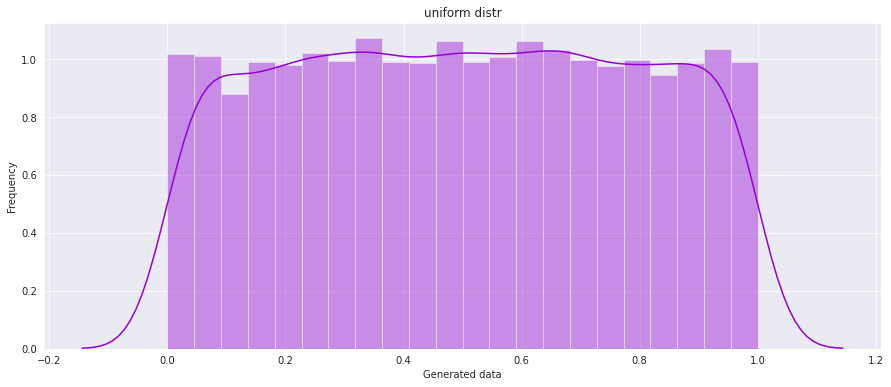

In [6]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.distplot(epsilon_uniform, ax=ax, color='darkviolet')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'uniform distr');

+ розподіл схожий на рівномірний
+ дані розподілені в інтервалі (0, 1)

**Перевіримо значення математичного сподівання та дисперсії, порівняємо з теоретичними:**

$M(\epsilon) = \int_0^1 x \,dx = \frac{1}{2}$

$D(\epsilon) = \int_0^1 (x - \frac{1}{2})^2 \,dx = \frac{1}{12}$

In [7]:
print('M(epsilon) = %s\nD(epsilon) = %s' % (epsilon_uniform.mean(), epsilon_uniform.std(ddof=1)**2))

M(epsilon) = 0.5011038003211244
D(epsilon) = 0.08240646187590683


+ значення математичного очікування та дисперсії подібні до теоретичних

#### 2. Згенеруємо $N$ чисел $x_i$ з експоненційного розподілу

In [8]:
x_exp = -np.log(epsilon_uniform) / lambda_1

**Побудуємо гістрограму та KDE plot для згенерованих даних**

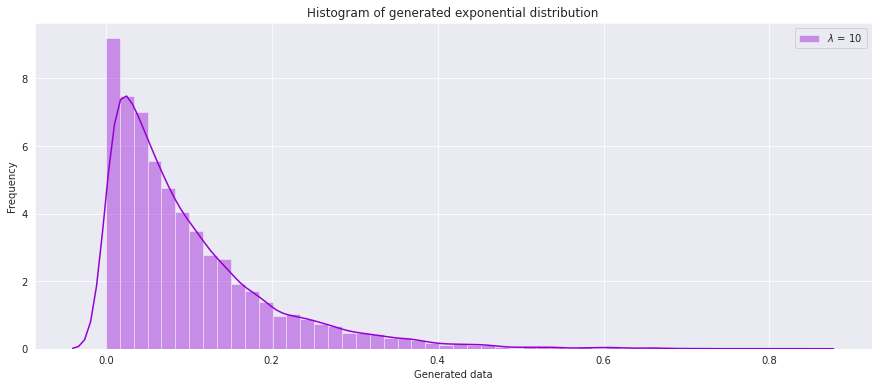

In [9]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.distplot(x_exp, ax=ax, color='darkviolet', label=f'$\lambda$ = {lambda_1}')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Histogram of generated exponential distribution');
ax.legend();

+ розподіл даних подібний до експоненційного

**Перевіримо значення математичного сподівання та дисперсії, порівняємо з теоретичними:**

$\mu = \frac{1}{\lambda}$

$D(x) = \sigma^2$, де $\sigma = \frac{1}{\lambda}$

In [10]:
print('M(x) = %s\nstd(x) = %s\nD(x) = %s' % (x_exp.mean(), x_exp.std(ddof=1), x_exp.std(ddof=1)**2))

M(x) = 0.09936505505555451
std(x) = 0.09930108848321913
D(x) = 0.009860706173952115


+ математичне сподівання приблизно дорівнює стандартному квадратичному відхиленню

#### 3. Виконаємо перевірку на відповідність експоненційному закону розподілу, використавши формулу:

$F(x) = 1 - e^{-\lambda x}$

In [11]:
def exp_cdf(x, l):
    return 1 - np.exp(-l*x) # F


def exp_pdf(x, l):
    return l*np.exp(-l*x) # f

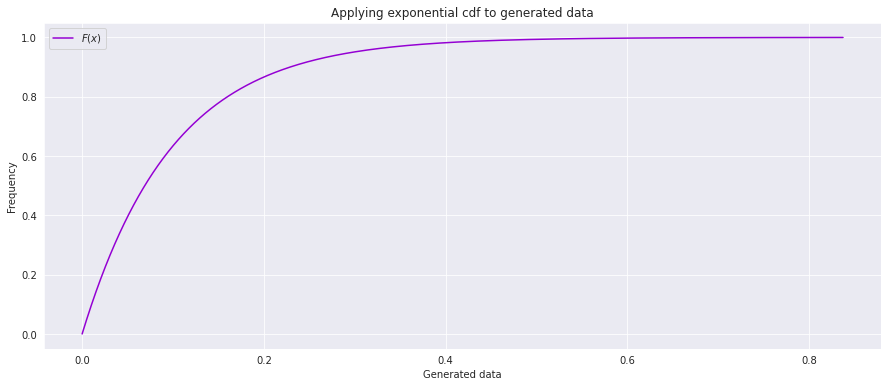

In [12]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

x = np.linspace(0,1,100000)
sns.lineplot(x_exp, exp_cdf(x_exp, 1/((x.mean() + x.std(ddof=1)) / 2)), ax=ax, color='darkviolet', label='$F(x)$')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Applying exponential cdf to generated data');
ax.legend();

#### 4. Відповідність заданому закону розподілу перевірити за допомогою критерію $\chi^2$

$H_0:$ дані мають експоненційний розподіл з заданим параметром $\lambda$

$H_1: H_0$ не виконується

In [316]:
def create_bins(x, n_bins=30):
    start = x.min()
    finish = x.max() + 1e-9
    h = (finish - start) / n_bins
    n = x.size
    l = 1/((x.mean() + x.std(ddof=1)) / 2)
    
    obs_freq = {}
    exp_freq = {}
    
    current = start

    i = 0
    while current <= finish:
        obs_freq[i] = np.sum((x >= current) & (x < (current+h)))
        p_i = np.exp(-l*current) - np.exp(-l*(current+h))
        exp_freq[i] = p_i * n
        i += 1
        current += h
    return normilize_bins(obs_freq, exp_freq)

In [317]:
def normilize_bins(obs_freq, exp_freq):
    assert len(obs_freq) > 2 or len(exp_freq) > 2
        
    for i in sorted(obs_freq.keys(), reverse=True):
        if obs_freq[i] <= 5:
            obs_freq[i-1] += obs_freq[i]
            exp_freq[i-1] += exp_freq[i]
            del obs_freq[i], exp_freq[i]
            
    for i in sorted(exp_freq.keys(), reverse=True):
        if exp_freq[i] <= 5:
            obs_freq[i-1] += obs_freq[i]
            exp_freq[i-1] += exp_freq[i]
            del obs_freq[i], exp_freq[i]
            
    return obs_freq, exp_freq

In [318]:
observed_freq, expected_freq = create_bins(x_exp)

In [320]:
stat_val, p_value = stats.chisquare(list(observed_freq.values()), list(expected_freq.values()), ddof=1)

+ **Ймовірність отримати значення статистики як в експерименті чи ще більше екстримальне при справедливості нульової гіпотези**
+ **Чим нижче p-value, тим сильніше дані свідчать проти прийняття нульової гіпотези на користь альтернативи**

$p = P(T \geq t|H_0)$

In [321]:
alpha = 0.05
if p_value < alpha:
    print(f'Не можемо прийняти нульову гіпотезу на рівні значемості alpha={alpha}.')
    print('Значення статистики:')
    print('\t- stat_val = %s\n\t- p-value = %s' % (round(stat_val, 5), round(p_value, 5)))
else:
    print('Можемо прийняти нульову гіпотезу про розподіл данних з заданим параметром.')
    print('Значення статистики:')
    print('\t- stat_val = %s\n\t- p-value = %s' % (round(stat_val, 5), round(p_value, 5)))

Можемо прийняти нульову гіпотезу про розподіл данних з заданим параметром.
Значення статистики:
	- stat_val = 22.15725
	- p-value = 0.45054


### Генерація даних з параметром $\lambda$ = 1.2

#### 1. Згенеруємо $N$ випадкових, рівномірно розподілених в інтервалі (0, 1) чисел $\epsilon_i$

In [324]:
n = 10000
lambda_2 = 1.2

In [325]:
epsilon_uniform = np.random.uniform(low=0, high=1, size=n)

**Побудуємо гістрограму даного розподілу:**

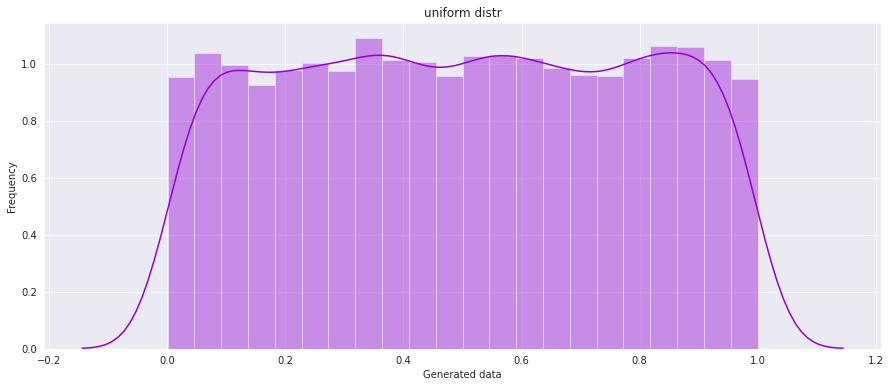

In [326]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.distplot(epsilon_uniform, ax=ax, color='darkviolet')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'uniform distr');

+ розподіл схожий на рівномірний
+ дані розподілені в інтервалі (0, 1)

**Перевіримо значення математичного сподівання та дисперсії, порівняємо з теоретичними:**

$M(\epsilon) = \int_0^1 x \,dx = \frac{1}{2}$

$D(\epsilon) = \int_0^1 (x - \frac{1}{2})^2 \,dx = \frac{1}{12}$

In [327]:
print('M(epsilon) = %s\nD(epsilon) = %s' % (epsilon_uniform.mean(), epsilon_uniform.std(ddof=1)**2))

M(epsilon) = 0.502306820057431
D(epsilon) = 0.08273575386899397


+ значення математичного очікування та дисперсії подібні до теоретичних

#### 2. Згенеруємо $N$ чисел $x_i$ з експоненційного розподілу

In [328]:
x_exp = -np.log(epsilon_uniform) / lambda_2

**Побудуємо гістрограму та KDE plot для згенерованих даних**

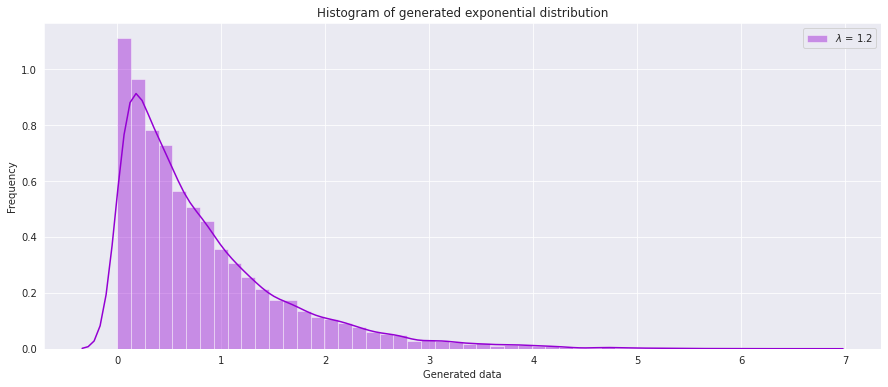

In [329]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.distplot(x_exp, ax=ax, color='darkviolet', label=f'$\lambda$ = {lambda_2}')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Histogram of generated exponential distribution');
ax.legend();

+ розподіл даних подібний до експоненційного

**Перевіримо значення математичного сподівання та дисперсії, порівняємо з теоретичними:**

$\mu = \frac{1}{\lambda}$

$D(x) = \sigma^2$, де $\sigma = \frac{1}{\lambda}$

In [333]:
print('M(x) = %s\nstd(x) = %s\nD(x) = %s' % (x_exp.mean(), x_exp.std(ddof=1), x_exp.std(ddof=1)**2))

M(x) = 0.8227344472249178
std(x) = 0.8139809215934534
D(x) = 0.6625649407181277


+ математичне сподівання приблизно дорівнює стандартному квадратичному відхиленню

#### 3. Виконаємо перевірку на відповідність експоненційному закону розподілу, використавши формулу:

$F(x) = 1 - e^{-\lambda x}$

In [334]:
def exp_cdf(x, l):
    return 1 - np.exp(-l*x) # F


def exp_pdf(x, l):
    return l*np.exp(-l*x) # f

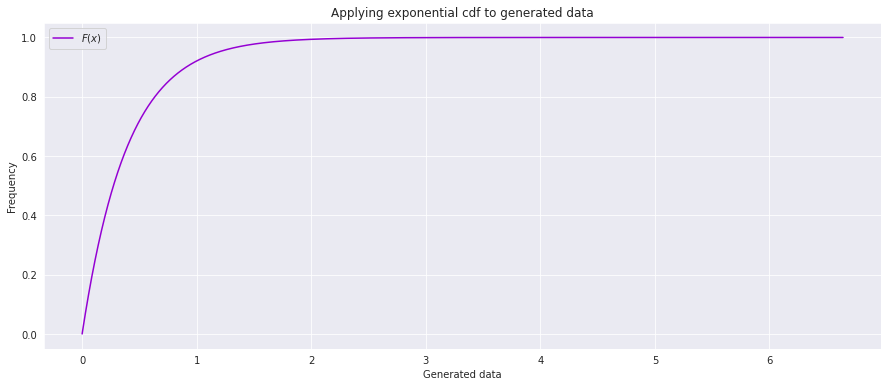

In [335]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

x = np.linspace(0,1,100000)
sns.lineplot(x_exp, exp_cdf(x_exp, 1/((x.mean() + x.std(ddof=1)) / 2)), ax=ax, color='darkviolet', label='$F(x)$')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Applying exponential cdf to generated data');
ax.legend();

#### 4. Відповідність заданому закону розподілу перевірити за допомогою критерію $\chi^2$

$H_0:$ дані мають експоненційний розподіл з заданим параметром $\lambda$

$H_1: H_0$ не виконується

In [316]:
def create_bins(x, n_bins=30):
    start = x.min()
    finish = x.max() + 1e-9
    h = (finish - start) / n_bins
    n = x.size
    l = 1/((x.mean() + x.std(ddof=1)) / 2)
    
    obs_freq = {}
    exp_freq = {}
    
    current = start

    i = 0
    while current <= finish:
        obs_freq[i] = np.sum((x >= current) & (x < (current+h)))
        p_i = np.exp(-l*current) - np.exp(-l*(current+h))
        exp_freq[i] = p_i * n
        i += 1
        current += h
    return normilize_bins(obs_freq, exp_freq)

In [317]:
def normilize_bins(obs_freq, exp_freq):
    assert len(obs_freq) > 2 or len(exp_freq) > 2
        
    for i in sorted(obs_freq.keys(), reverse=True):
        if obs_freq[i] <= 5:
            obs_freq[i-1] += obs_freq[i]
            exp_freq[i-1] += exp_freq[i]
            del obs_freq[i], exp_freq[i]
            
    for i in sorted(exp_freq.keys(), reverse=True):
        if exp_freq[i] <= 5:
            obs_freq[i-1] += obs_freq[i]
            exp_freq[i-1] += exp_freq[i]
            del obs_freq[i], exp_freq[i]
            
    return obs_freq, exp_freq

In [318]:
observed_freq, expected_freq = create_bins(x_exp)

In [319]:
observed_freq, expected_freq

({0: 2414,
  1: 1876,
  2: 1402,
  3: 1073,
  4: 814,
  5: 604,
  6: 441,
  7: 298,
  8: 264,
  9: 201,
  10: 146,
  11: 119,
  12: 81,
  13: 76,
  14: 41,
  15: 41,
  16: 32,
  17: 10,
  18: 13,
  19: 12,
  20: 9,
  21: 15,
  23: 10,
  25: 8},
 {0: 2448.874066128226,
  1: 1849.0872629919397,
  2: 1396.2023419051511,
  3: 1054.239580011604,
  4: 796.0315340443302,
  5: 601.0647059807733,
  6: 453.84983549613344,
  7: 342.6913460902098,
  8: 258.7581827736955,
  9: 195.3822234388128,
  10: 147.52852577141755,
  11: 111.39532314260805,
  12: 84.11199090589825,
  13: 63.510987845483875,
  14: 47.95565452281233,
  15: 36.21018785452363,
  16: 27.341461971625606,
  17: 20.644895457300386,
  18: 15.588475440163949,
  19: 11.770491502424411,
  20: 8.887621547113127,
  21: 11.778027387381172,
  23: 6.715130699752176,
  25: 7.255905156828193})

In [320]:
stat_val, p_value = stats.chisquare(list(observed_freq.values()), list(expected_freq.values()), ddof=1)

+ **Ймовірність отримати значення статистики як в експерименті чи ще більше екстримальне при справедливості нульової гіпотези**
+ **Чим нижче p-value, тим сильніше дані свідчать проти прийняття нульової гіпотези на користь альтернативи**

$p = P(T \geq t|H_0)$

In [321]:
alpha = 0.05
if p_value < alpha:
    print(f'Не можемо прийняти нульову гіпотезу на рівні значемості alpha={alpha}.')
    print('Значення статистики:')
    print('\t- stat_val = %s\n\t- p-value = %s' % (round(stat_val, 5), round(p_value, 5)))
else:
    print('Можемо прийняти нульову гіпотезу про розподіл данних з заданим параметром.')
    print('Значення статистики:')
    print('\t- stat_val = %s\n\t- p-value = %s' % (round(stat_val, 5), round(p_value, 5)))

Можемо прийняти нульову гіпотезу про розподіл данних з заданим параметром.
Значення статистики:
	- stat_val = 22.15725
	- p-value = 0.45054
